In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import json
import time
from matplotlib.ticker import MaxNLocator

In [3]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:92.0) Gecko/20100101 Firefox/92.0'
}

def load_top_date(day=7, month=10, year=2024, country="de"):
    year = f"{year}"
    month = f"{month:02}"
    day = f"{day:02}"

    csv_file = f"./data/top_{year}_{month}_{day}.csv"

    if not os.path.exists(csv_file):
        json_file = f"./data/top_{year}_{month}_{day}.json"

        # dont spam api in dev, save locally
        if not os.path.exists(json_file):
            api_url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/top/{country}.wikipedia/all-access/{year}/{month}/{day}"
            response = requests.get(api_url, headers=headers)
            
            if response.status_code != 200:
                print(f"Failed to fetch data, HTTP Status Code: {response.status_code}")
                return
            
            try:
                data = response.json()
            except json.JSONDecodeError as e:
                print(f"Failed to decode JSON: {e}, Response Text: {response.text}")
                return

            with open(json_file, 'w') as file:
                json.dump(data, file, indent=4)
            print(f"Data fetched from API and saved to {json_file}")
        else:
            with open(json_file, 'r') as file:
                data = json.load(file)
            print(f"Data loaded from local file: {json_file}")


        # Parse the JSON response and normalize it into a DataFrame
        # {"items":[{"project":"xx","access":"all-access","year":"2024","month":"09","day":"10","articles":[...]}]}
        items = data.get("items", [])
        rows = []

        for item in items:
            project = item.get("project")
            access = item.get("access")
            year = item.get("year")
            month = item.get("month")
            day = item.get("day")
            
            # Iterate through each article to extract rank and views
            for article in item.get("articles", []):
                rows.append({
                    "project": project,
                    "access": access,
                    "year": year,
                    "month": month,
                    "day": day,
                    "article_title": article.get("article"),
                    "views": article.get("views"),
                    "rank": article.get("rank"),
                })


        df = pd.DataFrame(rows)
        df.to_csv(csv_file, index=False)
        print(f"Data saved successfully to {csv_file}")
    else:
        print(f"Data loaded from local file: {csv_file}")
        df = pd.read_csv(csv_file)

    return df


In [4]:
start_date = "2024-10-09"
end_date = "2024-10-20"
date_range = pd.date_range(start=start_date, end=end_date)
for date in date_range:
    load_top_date(day=date.day,month=date.month,year=date.year)
    time.sleep(0.5)
    

Data loaded from local file: ./data/top_2024_10_09.csv
Data loaded from local file: ./data/top_2024_10_10.csv
Data loaded from local file: ./data/top_2024_10_11.csv
Data loaded from local file: ./data/top_2024_10_12.csv
Data loaded from local file: ./data/top_2024_10_13.csv
Data loaded from local file: ./data/top_2024_10_14.csv
Data fetched from API and saved to ./data/top_2024_10_15.json
Data saved successfully to ./data/top_2024_10_15.csv
Data fetched from API and saved to ./data/top_2024_10_16.json
Data saved successfully to ./data/top_2024_10_16.csv
Data fetched from API and saved to ./data/top_2024_10_17.json
Data saved successfully to ./data/top_2024_10_17.csv
Data fetched from API and saved to ./data/top_2024_10_18.json
Data saved successfully to ./data/top_2024_10_18.csv
Data fetched from API and saved to ./data/top_2024_10_19.json
Data saved successfully to ./data/top_2024_10_19.csv
Failed to fetch data, HTTP Status Code: 404


In [5]:
import glob

def load_data_for_topic(article="Linkin_Park"):
    file_pattern = "./data/top_*.csv"
    file_list = glob.glob(file_pattern)  # List of all files matching the pattern

    dataframes = []
    for file in file_list:
        df = pd.read_csv(file)
        if article is not None:
            df = df[df["article_title"].str.contains(article, case=False, na=False)] # prefilter to save memspace
        #else: # then limit rank to decrease size
        #    df = df[df["rank"] < 100]
            
        df = df[~df["article_title"].str.startswith(("Datei:","Spezial:","Special:","Wikipedia:"))]
        dataframes.append(df)

    combined_df = pd.concat(dataframes, ignore_index=True)
    # fix order by date
    combined_df = combined_df.sort_values(by=['year','month','day'], ascending=[True,True,True])
    combined_df.reset_index(drop=True, inplace=True) # Reset index (optional)
    return combined_df

In [6]:
df = load_data_for_topic(article=None)
view_df = df.sort_values(by='views', ascending=False)
print(view_df.head(n=10))

             project      access  year  month  day  \
6924    de.wikipedia  all-access  2024      1    8   
49496   de.wikipedia  all-access  2024      2   20   
7914    de.wikipedia  all-access  2024      1    9   
2966    de.wikipedia  all-access  2024      1    4   
45538   de.wikipedia  all-access  2024      2   16   
221285  de.wikipedia  all-access  2024      8   12   
286363  de.wikipedia  all-access  2024     10   17   
227202  de.wikipedia  all-access  2024      8   18   
200569  de.wikipedia  all-access  2024      7   22   
4946    de.wikipedia  all-access  2024      1    6   

                        article_title   views  rank  
6924                Franz_Beckenbauer  855385     2  
49496                  Andreas_Brehme  489584     2  
7914                Franz_Beckenbauer  427114     2  
2966                      Ausfallrate  412954     2  
45538   Alexei_Anatoljewitsch_Nawalny  357745     2  
221285                 Richard_Lugner  350068     2  
286363                     

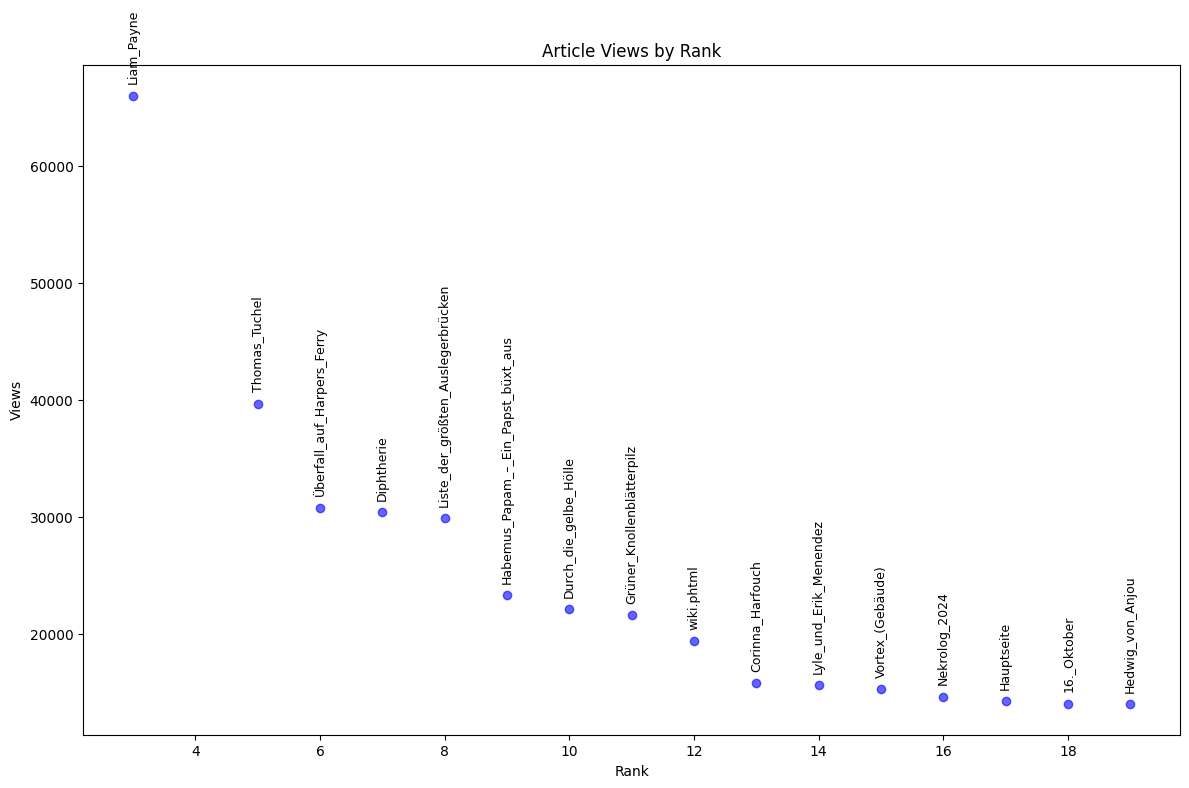

In [8]:
# TODO plot rank / views for a day

# plotting views vs. rank for a specific day or month
def plot_day(day,month,year, df):
    df_filtered = df[(df["year"] == year) & (df["month"] == month) & (df["day"] == day)].copy()
    df_filtered = df_filtered[df_filtered["rank"] < 20]

    plt.figure(figsize=(12, 8))
    plt.scatter(df_filtered["rank"], df_filtered["views"], color='blue', alpha=0.6)

    for _, row in df_filtered.iterrows():
        plt.text(row["rank"], row["views"]+1000, row["article_title"], fontsize=9, ha='center', va='bottom', rotation=90)

    plt.xlabel("Rank")
    plt.ylabel("Views")
    plt.title(f"Article Views by Rank")
    plt.tight_layout()
    plt.show()

plot_day(16,10,2024, df)

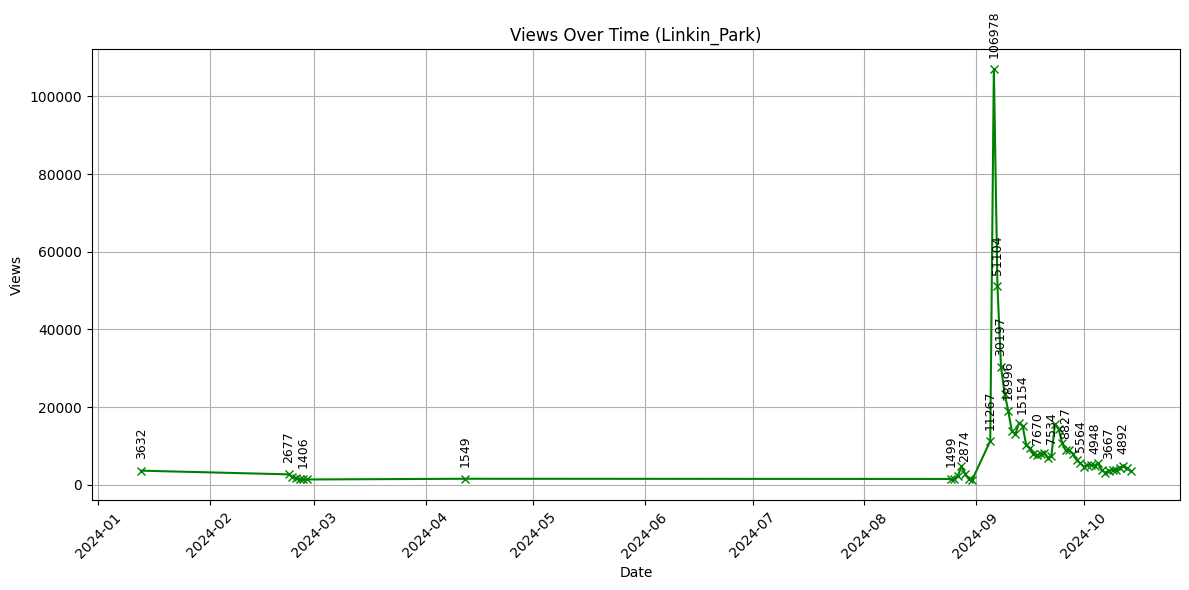

In [7]:
def view_over_time(df, article="Linkin_Park"):
    df_filtered = df[df["article_title"] == article].copy()

    # aggregate 3 columns into one
    df_filtered["date"] = pd.to_datetime(df_filtered[["year", "month", "day"]])

    # Sort by date to ensure proper line plotting
    df_filtered.sort_values(by="date", inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered["date"], df_filtered["views"], marker='x', linestyle='-', color='g')

    # label some dates if space
    last_labeled_dates = []
    for i, row in df_filtered.iterrows():
        current_date = row["date"]
        current_views = row["views"]
        
        # Check for existing labels in the last 3 days and within a 10,000 views difference
        if not any((abs((current_date - labeled_date).days) <= 3 and 
                     abs(current_views - labeled_views) < 10000)
                    for labeled_date, labeled_views in last_labeled_dates):
            # Plot the label
            plt.text(current_date, current_views + 3000, current_views,
                     fontsize=9, ha='center', va='bottom', rotation=90)
            # Add this point to the list of labeled points
            last_labeled_dates.append((current_date, current_views))


    plt.xlabel("Date")
    plt.ylabel("Views")
    plt.title(f"Views Over Time ({article})")

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

view_over_time(df)



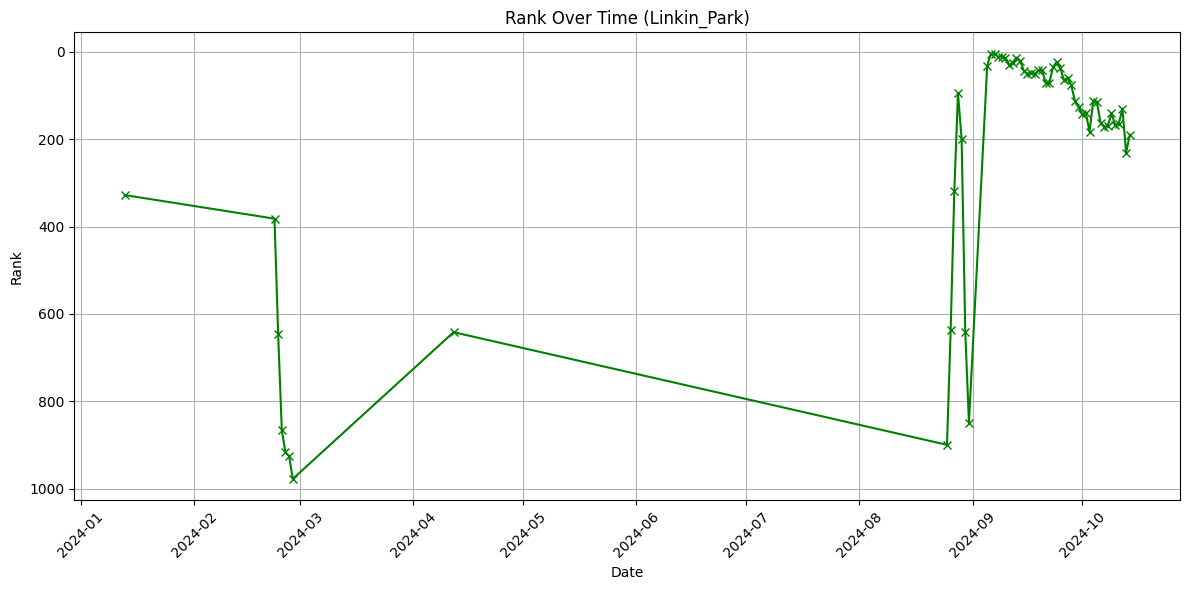

In [8]:
def rank_over_time(df, article="Linkin_Park"):
    df_filtered = df[df["article_title"] == article].copy()

    # aggregate 3 columns into one
    df_filtered["date"] = pd.to_datetime(df_filtered[["year", "month", "day"]])

    # Sort by date to ensure proper line plotting
    df_filtered.sort_values(by="date", inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered["date"], df_filtered["rank"], marker='x', linestyle='-', color='g')

    #for _, row in df_filtered.iterrows():
    #    plt.text(row["date"], row["rank"], row["rank"],
    #                 fontsize=9, ha='center', va='bottom', rotation=90)

    # Invert the y-axis so that rank 1 is at the top
    plt.gca().invert_yaxis()

    plt.xlabel("Date")
    plt.ylabel("Rank")
    plt.title(f"Rank Over Time ({article})")

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

rank_over_time(df)

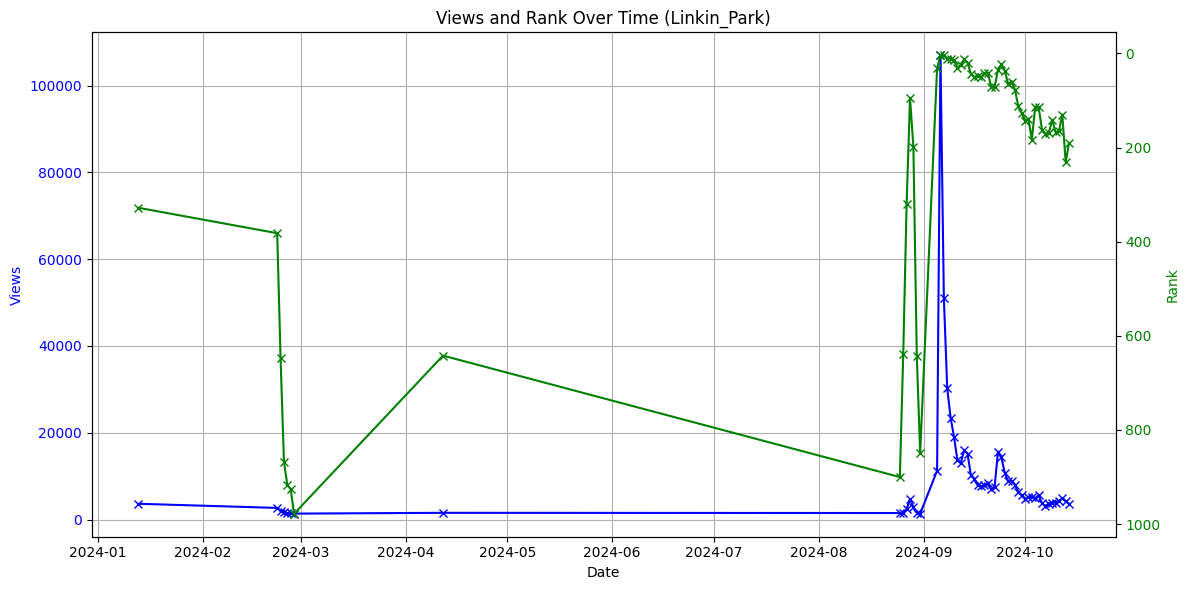

In [9]:
def combined_views_rank_plot(df, article="Linkin_Park"):
    df_filtered = df[df["article_title"] == article].copy()

    # Aggregate year, month, day into one date column
    df_filtered["date"] = pd.to_datetime(df_filtered[["year", "month", "day"]])

    # Sort by date to ensure proper line plotting
    df_filtered.sort_values(by="date", inplace=True)

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot views on primary y-axis
    ax1.plot(df_filtered["date"], df_filtered["views"], marker='x', linestyle='-', color='b', label='Views')
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Views", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Adding text labels for views
    #for _, row in df_filtered.iterrows():
    #    ax1.text(row["date"], row["views"], row["views"],
    #             fontsize=9, ha='center', va='bottom', rotation=45)

    # Create secondary y-axis for rank
    ax2 = ax1.twinx()
    ax2.plot(df_filtered["date"], df_filtered["rank"], marker='x', linestyle='-', color='g', label='Rank')
    ax2.set_ylabel("Rank", color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Invert the y-axis for rank
    ax2.invert_yaxis()

    # Adding text labels for ranks
    #for _, row in df_filtered.iterrows():
    #    ax2.text(row["date"], row["rank"], row["rank"],
    #             fontsize=9, ha='center', va='bottom', rotation=45)

    plt.title(f"Views and Rank Over Time ({article})")
    plt.xticks(rotation=45)
    ax1.grid(True)
    plt.tight_layout()
    plt.show()

combined_views_rank_plot(df)

['Der_Herr_der_Ringe_(Filmtrilogie)'
 'Der_Herr_der_Ringe:_Die_Gefährten_(Film)' 'Der_Herr_der_Ringe'
 'Der_Herr_der_Ringe:_Die_zwei_Türme_(Film)'
 'Der_Herr_der_Ringe:_Die_Rückkehr_des_Königs_(Film)'
 'Der_Herr_der_Ringe:_Die_Ringe_der_Macht'
 'Der_Herr_der_Ringe:_Die_Schlacht_der_Rohirrim']


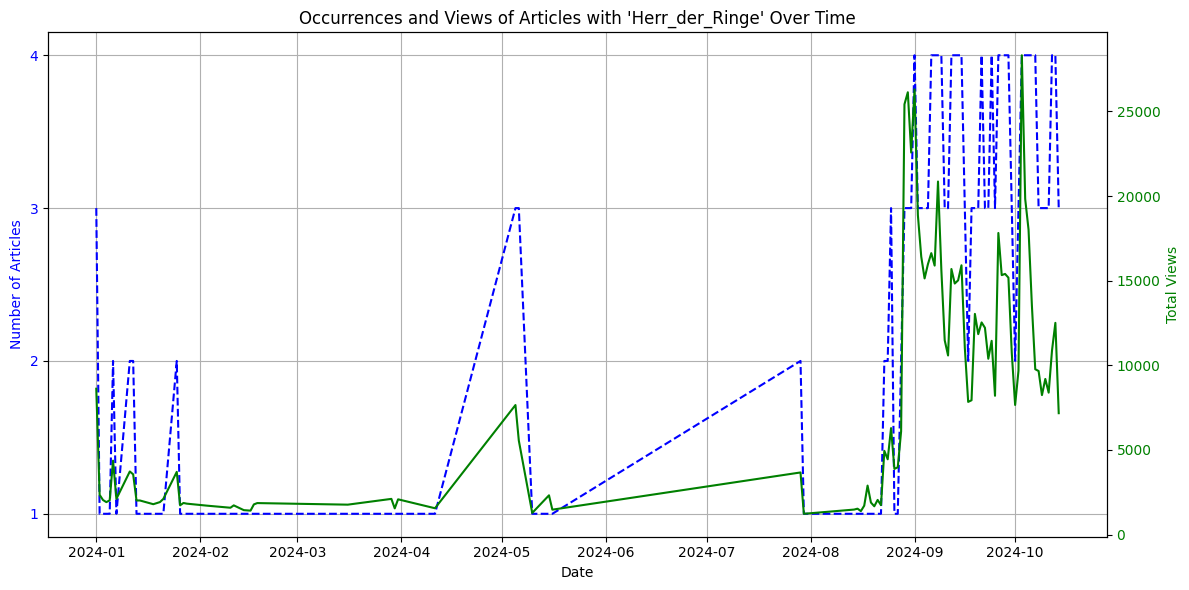

In [11]:
def plot_occurrence_and_views(df, keyword="Herr_der_Ringe"):
    # Filter the DataFrame for articles containing the keyword in the title
    df_filtered = df[df["article_title"].str.contains(keyword, case=False, na=False)].copy()
    print(df_filtered['article_title'].unique())

    # Aggregate year, month, day into one date column
    df_filtered["date"] = pd.to_datetime(df_filtered[["year", "month", "day"]])

    # Group by date and calculate total views and number of articles (occurrences)
    df_grouped = df_filtered.groupby("date").agg(
        occurrence=("article_title", "count"),
        total_views=("views", "sum")
    ).reset_index()

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot occurrence (number of articles) on the primary y-axis
    ax1.plot(df_grouped["date"], df_grouped["occurrence"], marker='none', linestyle='--', color='b', label='Article Occurrences')
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Number of Articles", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Ensure that the y-axis uses whole numbers
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Create secondary y-axis for total views
    ax2 = ax1.twinx()
    ax2.plot(df_grouped["date"], df_grouped["total_views"], marker='none', linestyle='-', color='g', label='Total Views')
    ax2.set_ylabel("Total Views", color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    plt.title(f"Occurrences and Views of Articles with '{keyword}' Over Time")
    plt.xticks(rotation=45)
    ax1.grid(True)
    plt.tight_layout()
    plt.show()

plot_occurrence_and_views(df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


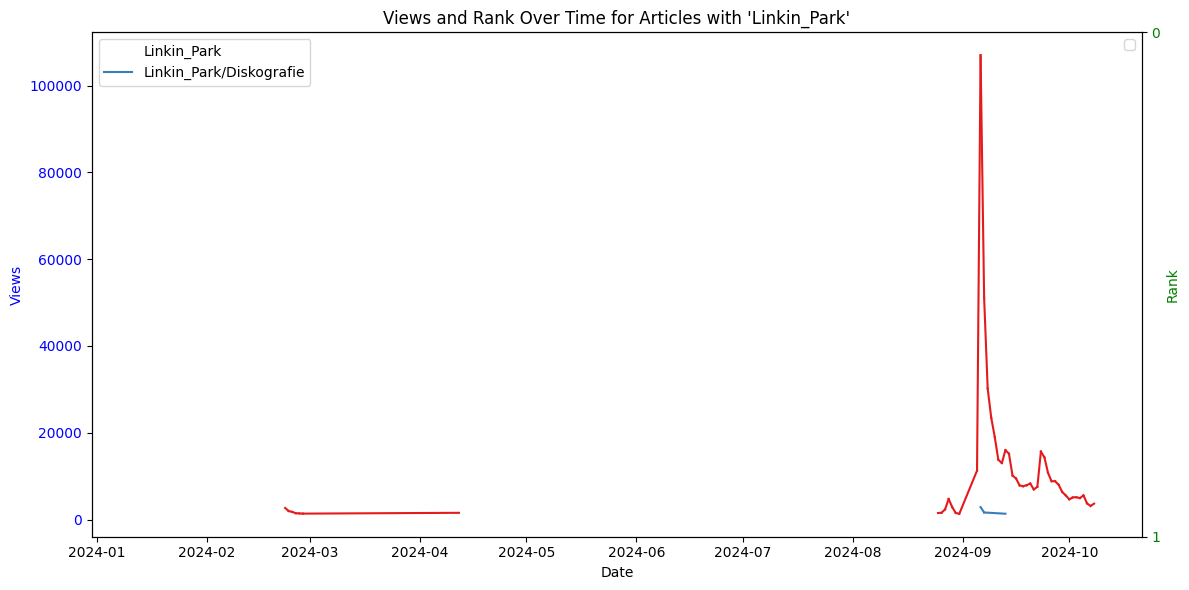

In [36]:
def plot_individual_articles(df, keyword="Linkin_Park"):
    # Filter the DataFrame for articles containing the keyword in the title
    df_filtered = df[df["article_title"].str.contains(keyword, case=False, na=False)].copy()

    # Aggregate year, month, day into one date column
    df_filtered["date"] = pd.to_datetime(df_filtered[["year", "month", "day"]])

    # Sort values by date to ensure proper line plotting
    df_filtered.sort_values(by="date", inplace=True)

    # Create a figure and primary y-axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Views", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create secondary y-axis for occurrences
    ax2 = ax1.twinx()

    # Assign colors to each article
    unique_articles = df_filtered["article_title"].unique()
    colors = plt.cm.Set1.colors  # Use a colormap with distinct colors
    color_map = {article: colors[i % len(colors)] for i, article in enumerate(unique_articles)}


    # Plot views for each article on the primary y-axis
    for article in unique_articles:
        df_article = df_filtered[df_filtered["article_title"] == article]

        # Create a list of neighboring dates
        dates = df_article["date"].values
        views = df_article["views"].values

        # Loop to identify neighboring dates
        for i in range(len(dates)):
            # Check if previous and next dates have data
            has_previous = (i > 0 and dates[i] - dates[i - 1] == pd.Timedelta(days=1))
            has_next = (i < len(dates) - 1 and dates[i + 1] - dates[i] == pd.Timedelta(days=1))
            
            if has_previous or has_next:
                # Plot as line if there are neighboring dates
                ax1.plot(dates[i:i + 2], views[i:i + 2], marker='none', linestyle='-', color=color_map[article], label=article if i == 0 else "")
            else:
                # Plot as point if no neighboring dates
                ax1.plot(dates[i], views[i], marker='none', linestyle='', color=color_map[article], label=article if i == 0 else "")


        #ax1.plot(df_article["date"], df_article["views"], marker='none', linestyle='-', label=article)
        #ax2.plot(df_article["date"], df_article["rank"], marker='none', linestyle='--', label=f"{article} Rank")

    ax2.invert_yaxis()
    ax2.set_ylabel("Rank", color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True)) 

    # Display legends for both primary and secondary axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f"Views and Rank Over Time for Articles with '{keyword}'")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_individual_articles(df)

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corr(df):
    #df = df[df['article_title'].str.contains('herr_der_ringe', case=False, na=False)].copy()

    # Combine year, month, and day into a date column
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

    # Filter the DataFrame for dates within the specified range
    start_date = '2024-09-01'
    end_date = '2024-10-08'
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # AT LEAST x OCCURRENCES
    # Count unique dates for each article
    article_counts = df.groupby('article_title')['date'].nunique()
    valid_articles = article_counts[article_counts >= 10].index
    df = df[df['article_title'].isin(valid_articles)]

    #print(df.head(n=10))

    # Pivot the DataFrame to have articles as columns and dates as rows
    df_pivot = df.pivot_table(index='date', columns='article_title', values='views', aggfunc='sum').fillna(0)
    #print(df_pivot.head(n=10))
    correlation_matrix = df_pivot.corr()
    return df, correlation_matrix

    # Plot the heatmap for better visualization
    #plt.figure(figsize=(10, 8))
    #sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    #plt.title('Correlation Heatmap of Article Views')
    #plt.show()

df, correlation_matrix = corr(df)

In [13]:
threshold = 0.9
article_of_interest = "Emily_Armstrong" 

if article_of_interest in correlation_matrix.columns:
    correlations = correlation_matrix[article_of_interest]

    for article, correlation in correlations.items():
        if article != article_of_interest and correlation >= threshold:  # Skip self-correlation
            print(f"{article_of_interest} & {article}:\t {correlation:.2f}")

Emily_Armstrong & Chester_Bennington:	 0.98
Emily_Armstrong & Chris_Cornell:	 0.98
Emily_Armstrong & Dead_Sara:	 0.92
Emily_Armstrong & Linkin_Park:	 0.99
Emily_Armstrong & Mike_Shinoda:	 0.96
Emily_Armstrong & Rob_Bourdon:	 0.98


In [14]:
threshold = 0.9
correlation_data = []

# Get the first and last occurrence of each valid article
first_occurrence = df.groupby('article_title')['date'].min()
last_occurrence = df.groupby('article_title')['date'].max()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] >= threshold:
            article1 = correlation_matrix.columns[i]
            article2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            correlation_data.append((
                article1, 
                article2, 
                correlation_value,
                first_occurrence[article1],
                last_occurrence[article1],
                first_occurrence[article2],
                last_occurrence[article2]
            ))
            #print(f"{article1} and {article2}: {correlation_value:.2f}")

correlation_df = pd.DataFrame(correlation_data, columns=[
            "Article A", 
            "Article B", 
            "Correlation", 
            "A von", 
            "A bis",
            "B von", 
            "B bis"
        ])
correlation_df.sort_values(by="Correlation", ascending=False, inplace=True)
print(correlation_df.to_string(index=False, float_format='%.2f'))

                                            Article A                                       Article B  Correlation      A von      A bis      B von      B bis
                                     Leighton_Meester                                      Adam_Brody         1.00 2024-09-26 2024-10-08 2024-09-26 2024-10-08
                                         Rolf_Brendel                                    Danny_Huston         1.00 2024-09-20 2024-10-06 2024-09-20 2024-10-06
                                        Katarina_Witt                                    Danny_Huston         1.00 2024-09-20 2024-10-08 2024-09-20 2024-10-06
                                         Rolf_Brendel                                   Katarina_Witt         1.00 2024-09-20 2024-10-06 2024-09-20 2024-10-08
                                            Thüringen                    Landtagswahl_in_Sachsen_2024         1.00 2024-09-01 2024-10-08 2024-09-01 2024-10-01
                                        Chris_

In [15]:
filter_value = 'Emily_Armstrong'
selected_df = correlation_df[(correlation_df['Article A']==filter_value) | (correlation_df['Article B']==filter_value)]
print(selected_df.to_string(index=False, float_format='%.2f'))

      Article A          Article B  Correlation      A von      A bis      B von      B bis
    Linkin_Park    Emily_Armstrong         0.99 2024-09-05 2024-10-08 2024-09-06 2024-10-08
Emily_Armstrong Chester_Bennington         0.98 2024-09-06 2024-10-08 2024-09-03 2024-10-08
    Rob_Bourdon    Emily_Armstrong         0.98 2024-09-05 2024-09-25 2024-09-06 2024-10-08
Emily_Armstrong      Chris_Cornell         0.98 2024-09-06 2024-10-08 2024-09-06 2024-10-05
   Mike_Shinoda    Emily_Armstrong         0.96 2024-09-06 2024-09-28 2024-09-06 2024-10-08
Emily_Armstrong          Dead_Sara         0.92 2024-09-06 2024-10-08 2024-09-06 2024-09-27


In [19]:
# Prepare data for force-directed graph
nodes = []
edges = []

sum_views = df.groupby('article_title')['views'].sum()

# Determine the maximum values for scaling
max_views = sum_views.max()
max_correlation = correlation_df["Correlation"].max()

# Set minimum and maximum node and link sizes
min_node_size = 4
max_node_size = 20

min_link_width = 1
max_link_width = 5

# Create nodes and edges from the correlation DataFrame
for index, row in correlation_df.iterrows():
    article_a = row["Article A"]
    article_b = row["Article B"]
    correlation_value = row["Correlation"]

    # Create nodes if they don't already exist
    if not any(node['id'] == article_a for node in nodes):
        size = int((sum_views[article_a] / max_views) * (max_node_size - min_node_size) + min_node_size)
        nodes.append({'id': article_a, 'views': int(sum_views[article_a]), 'size': size})
    if not any(node['id'] == article_b for node in nodes):
        size = int((sum_views[article_b] / max_views) * (max_node_size - min_node_size) + min_node_size)
        nodes.append({'id': article_b, 'views': int(sum_views[article_b]), 'size': size})

    # Create edges with scaled width
    width = (correlation_value / max_correlation) * (max_link_width - min_link_width) + min_link_width
    edges.append({
        'source': article_a,
        'target': article_b,
        'value': correlation_value,
        'width': width
    })

# Save nodes and edges to a JSON file
with open('graph_data.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': edges}, f)